In [1]:
#################################################################
# MLND Capstone > Crypto Ethereum Future Price RNN Classifier 
# Input - Ethereum minute price data, exchange Gemini, year 2018
# Output - A Prediction better than random 0.5
#################################################################

### 1. Check installed python and packages

In [2]:
# check python version
import sys
sys.version

'3.5.2 (default, Nov 12 2018, 13:43:14) \n[GCC 5.4.0 20160609]'

In [3]:
# check tensorflow, keras version and GPU
import tensorflow as tf

# Check TensorFlow Version
print (tf.VERSION)

# Check Keras Version
print(tf.keras.__version__)

# Check for a GPU
# print (tf.test.gpu_device_name())
# notice - this code line uses GPU VRam
# if executed and GPU VRam is low, then restart notebook kernel to free GPU VRam

1.12.0
2.1.6-tf


In [4]:
# ignore warnings
import warnings
warnings.filterwarnings('ignore')

### 2. Data Exploration

#### 2.1 Load and Preview Ethereum Data 

In [5]:
import pandas as pd
import numpy as np

preview_data_eth = './data/minute/gemini_ETHUSD_2018_1min.csv'

df_ETH = pd.read_csv(preview_data_eth, parse_dates=True, skiprows=2, names=['Unix Timestamp', 'Date', 'Symbol', 'Open', 'High', 'Low', 'Close', 'Volume From', 'Volume To'])
df_ETH.set_index('Date', inplace=True)
df_ETH.sort_index(inplace=True)
df_ETH_close_price = df_ETH['Close']


<p>The list of columns in the dataset
</p>

In [6]:
df_ETH.columns

Index(['Unix Timestamp', 'Symbol', 'Open', 'High', 'Low', 'Close',
       'Volume From', 'Volume To'],
      dtype='object')

<p>Preview top 5 data points:</p>

In [7]:
print(df_ETH.head())

                     Unix Timestamp  Symbol    Open    High     Low   Close  \
Date                                                                          
2018-01-01 00:00:00      1514764800  ETHUSD  736.11  739.47  736.11  737.98   
2018-01-01 00:01:00      1514764860  ETHUSD  737.98  737.98  737.97  737.98   
2018-01-01 00:02:00      1514764920  ETHUSD  737.98  737.98  736.03  736.03   
2018-01-01 00:03:00      1514764980  ETHUSD  736.03  738.79  736.03  738.29   
2018-01-01 00:04:00      1514765040  ETHUSD  738.29  738.29  738.29  738.29   

                     Volume From  Volume To  
Date                                         
2018-01-01 00:00:00     0.587303        NaN  
2018-01-01 00:01:00     2.410785        NaN  
2018-01-01 00:02:00     1.613000        NaN  
2018-01-01 00:03:00     1.135121        NaN  
2018-01-01 00:04:00     0.000000        NaN  


<p>Preview last 5 data points:</p>

In [8]:
print(df_ETH.tail())

                     Unix Timestamp  Symbol   Open   High     Low  Close  \
Date                                                                       
2018-12-31 23:55:00   1546300500000  ETHUSD  130.8  130.8  130.80  130.8   
2018-12-31 23:56:00   1546300560000  ETHUSD  130.8  130.8  130.00  130.0   
2018-12-31 23:57:00   1546300620000  ETHUSD  130.0  130.0  128.53  130.0   
2018-12-31 23:58:00   1546300680000  ETHUSD  130.0  130.0  130.00  130.0   
2018-12-31 23:59:00   1546300740000  ETHUSD  130.0  130.8  130.00  130.8   

                     Volume From  Volume To  
Date                                         
2018-12-31 23:55:00     0.000000        NaN  
2018-12-31 23:56:00    79.267075        NaN  
2018-12-31 23:57:00    44.386537        NaN  
2018-12-31 23:58:00     7.966173        NaN  
2018-12-31 23:59:00     8.688215        NaN  


#### Show basic statistics:

In [9]:
minimum_price = np.min(df_ETH_close_price)
maximum_price = np.max(df_ETH_close_price)
mean_price = np.mean(df_ETH_close_price)
median_price = np.median(df_ETH_close_price)
std_price = np.std(df_ETH_close_price)

print ("Statistics for Ethereum Close Price on exchange Gemini in year 2018:\n")
print ("Minimum price: ${:,.2f}".format(minimum_price))
print ("Maximum price: ${:,.2f}".format(maximum_price))
print ("Mean price: ${:,.2f}".format(mean_price))
print ("Median price: ${:,.2f}".format(median_price))
print ("Standard deviation of prices: ${:,.2f}".format(std_price))

Statistics for Ethereum Close Price on exchange Gemini in year 2018:

Minimum price: $80.83
Maximum price: $1,420.00
Mean price: $505.52
Median price: $466.72
Standard deviation of prices: $292.08


#### Data Visualization - See Ethereum price in 2018

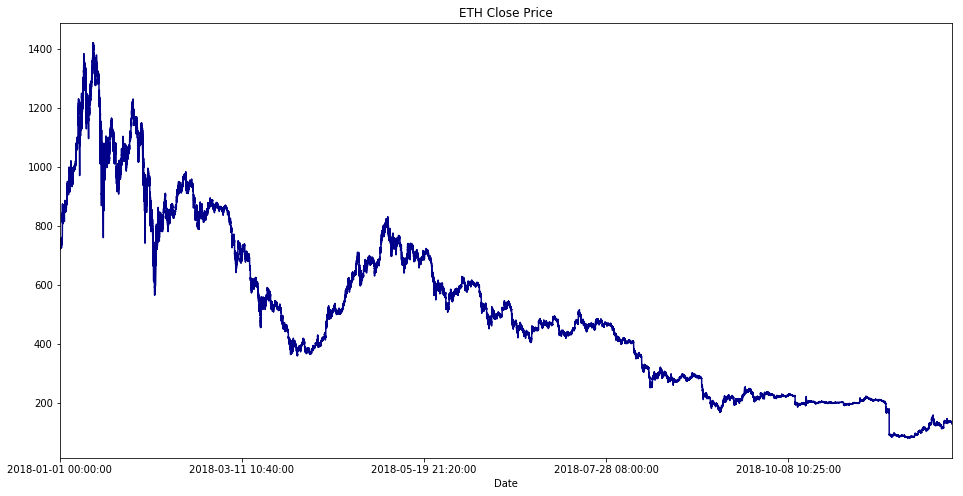

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

df_ETH_close_price.plot(label='ETH',figsize=(16,8),title='ETH Close Price',color='darkblue')
plt.show()

<p>As you can see the Ethereum price in 2018 is on bear trend.<p>

#### 2.2 Load Dataset from the two csv files

In [11]:
################################################
# load Dataset from the two csv files
#   gemini_BTCUSD_2018_1min.csv
#   gemini_ETHUSD_2018_1min.csv
################################################

# import packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import datetime as time
from datetime import datetime
import warnings
import os
from tqdm import tnrange, tqdm_notebook
import time

data_folder = './data/minute/'
data_files = ['gemini_BTCUSD_2018_1min.csv', 'gemini_ETHUSD_2018_1min.csv']

def date_format(date_str):
    return time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(date_str))
    
def build_dataset():
    
    df_main = pd.DataFrame() 
    
    for file in tqdm_notebook(data_files):
        if file.endswith('.csv'):
            
            # get info from filename
            exchange, pair, year, _ = file.replace('.csv', '').split('_')
        
            # load data .csv file
            file_path = os.path.join(data_folder, file)
            df = pd.read_csv(file_path, parse_dates=True, skiprows=2, names=['Date', 'Symbol', 'Open', 'High', 'Low', 'Close', 'Volume'])
            
            # date already in correct format yyyy-mm-dd hh:mm:ss
            # no need to reformat
            # df['Date'] = df['Date'].apply(lambda x: date_format(x))
            
            # set Date as index column
            df.set_index('Date', inplace=True)

            # rename columns
            rename_cols_from = ['Close', 'Volume']
            rename_cols_to = ['{}_{}_Close'.format(exchange, pair), '{}_{}_Volume'.format(exchange, pair)]
            df.rename(columns={rename_cols_from[0]: rename_cols_to[0], rename_cols_from[1]: rename_cols_to[1]}, inplace=True)

            # reduce to only columns you want to keep
            df = df[[rename_cols_to[0], rename_cols_to[1]]]
                        
            # join all csv data into one dataframe
            if len(df_main) == 0:  
                df_main = df
            else:
                df_main = df_main.join(df)
        
            
    # fill any missing data
    df_main.fillna(method="ffill", inplace=True)

    # delete any na
    df_main.dropna(inplace=True)
    
    return df_main
            
df_main = build_dataset()          
        
# order time sequence ASC
# 2018-01-01 to 2018-12-31
df_main.sort_index(inplace=True)

# remove any bad data
# the following index is isolated and not useful to predict sequence future data
# index=0, index value=2017-09-22 19:00:00
df_main.drop(df_main.index[0], inplace=True)


#### 2.3 Loaded data verification

In [12]:
# Data Exploration - preview first 5 records
df_main.head()

,gemini_BTCUSD_Close,gemini_BTCUSD_Volume,gemini_ETHUSD_Close,gemini_ETHUSD_Volume
Date,,,,
2018-01-01 00:01:00,13800.00,0.933856,737.98,2.410785
2018-01-01 00:02:00,13775.00,1.747634,736.03,1.613000
2018-01-01 00:03:00,13772.85,1.040767,738.29,1.135121
2018-01-01 00:04:00,13750.00,6.171053,738.29,0.000000
2018-01-01 00:05:00,13700.00,2.305962,735.00,66.676885


In [13]:
# Data Exploration - preview last 5 records
df_main.tail()

,gemini_BTCUSD_Close,gemini_BTCUSD_Volume,gemini_ETHUSD_Close,gemini_ETHUSD_Volume
Date,,,,
2018-12-31 23:55:00,3685.70,3.279082,130.8,0.000000
2018-12-31 23:56:00,3686.38,8.244595,130.0,79.267075
2018-12-31 23:57:00,3686.38,0.089801,130.0,44.386537
2018-12-31 23:58:00,3686.38,0.117334,130.0,7.966173
2018-12-31 23:59:00,3692.35,4.107691,130.8,8.688215


The data looks correct and well formatted. 

#### The list of columns in joined dataset:

In [14]:
for c in df_main.columns:
    print(c)

gemini_BTCUSD_Close
gemini_BTCUSD_Volume
gemini_ETHUSD_Close
gemini_ETHUSD_Volume


### 3. Technical Analysis    

#### 3.1 Bitcoin and Ethereum Close Price and Volume

We will plot the price and volume for both coins, to see the overview price trend.

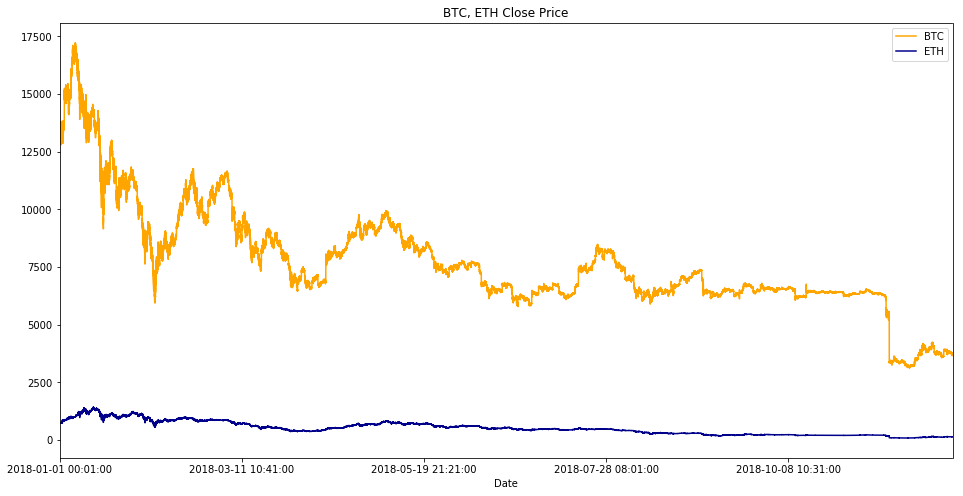

In [15]:
df_main['gemini_BTCUSD_Close'].plot(label='BTC',figsize=(16,8),title='BTC, ETH Close Price',color=['orange']);
df_main['gemini_ETHUSD_Close'].plot(label='ETH',figsize=(16,8),color=['darkblue'])
plt.legend();

The bitcoin price is much higher than ethereum. Both coins are on bear trend.

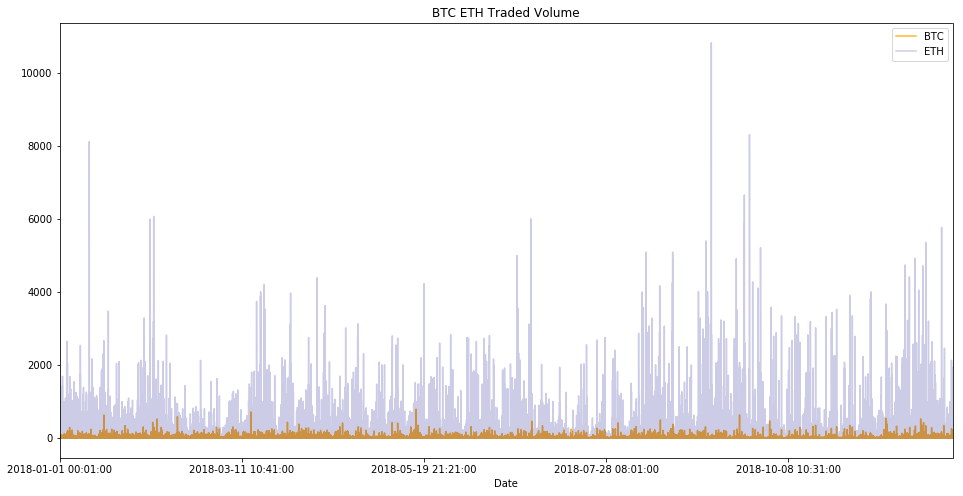

In [16]:
df_main['gemini_BTCUSD_Volume'].plot(label='BTC',figsize=(16,8),title='BTC ETH Traded Volume',color='orange',alpha=0.8)
df_main['gemini_ETHUSD_Volume'].plot(label='ETH',color='darkblue',alpha=0.2)
plt.legend();

The volume (number of coins traded) in ethereum is higher than bitcoin, this likely because bitcoin is much more expensive than ethereum. 

#### 3.2 Correlation between bitcoin and ethereum

We will plot the log price and scatter plots to see correlated patterns.

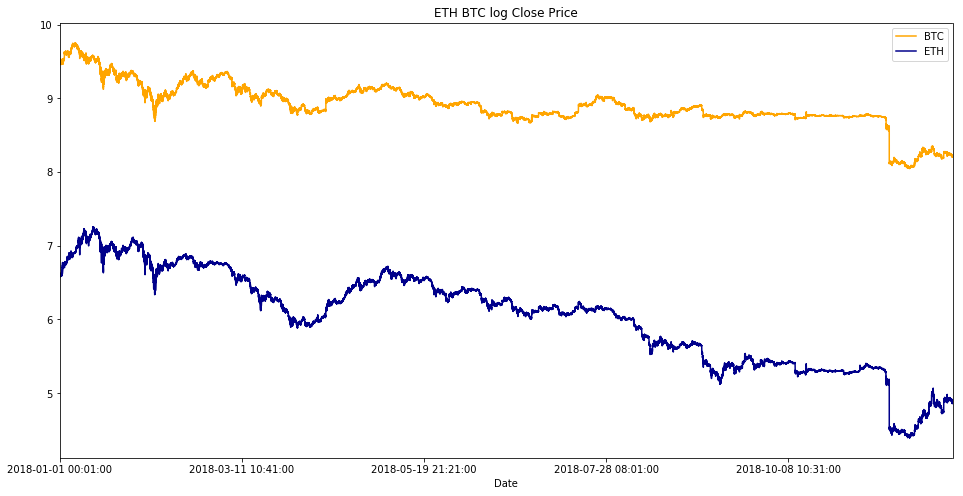

In [17]:
plot_cols = ['gemini_ETHUSD_Close', 'gemini_BTCUSD_Close']
df_main_logged = df_main[plot_cols]
df_main_logged = np.log(df_main_logged)
df_main_logged['gemini_BTCUSD_Close'].plot(label='BTC',figsize=(16,8),title='ETH BTC log Close Price',color='orange')
df_main_logged['gemini_ETHUSD_Close'].plot(label='ETH',color='darkblue')
plt.legend();

Looking at the log price of both coins, you can clearly see there are correlated patterns.

In [18]:
# resample from minutes to daily for quicker plot
df_main_daily = df_main[:]
df_main_daily.index = pd.to_datetime(df_main_daily.index)
df_main_daily = df_main_daily.resample('D').mean()

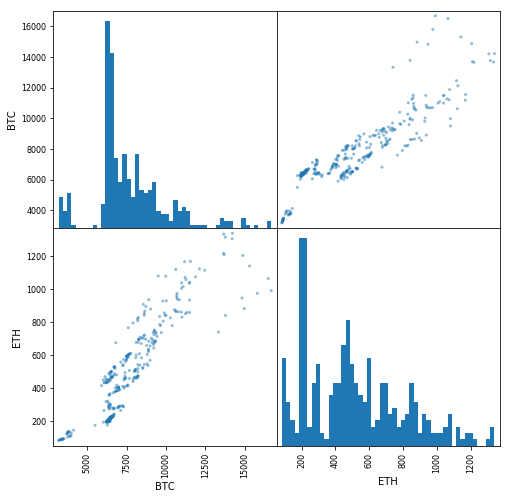

In [19]:
# scatter plot for correlation patterns
from pandas.plotting import scatter_matrix

c_comp = pd.concat([df_main_daily['gemini_BTCUSD_Close'],df_main_daily['gemini_ETHUSD_Close']],axis=1)
c_comp.columns = ['BTC','ETH']
scatter_matrix(c_comp,figsize=(8,8),alpha=0.5,hist_kwds={'bins':50});

The scatter plot show both coins are correlated, by looking at the dotted graph, there is a line pattern of both coins price going up together.

#### 3.3 Mean Reversion in bitcoin and ethereum

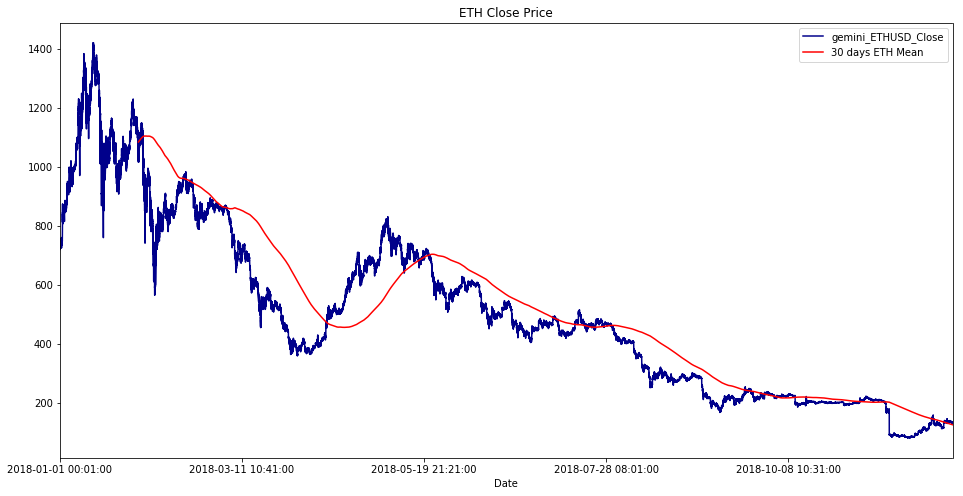

In [ ]:
minutes_in_30days = 60*24*30

df_rm = df_main[plot_cols]

df_rm['30 days ETH Mean'] = df_rm['gemini_ETHUSD_Close'].rolling(window=minutes_in_30days).mean()
df_rm[['gemini_ETHUSD_Close', '30 days ETH Mean']].plot(label='ETH',figsize=(16,8),title='ETH Close Price',color=['darkblue','red'])
plt.show()

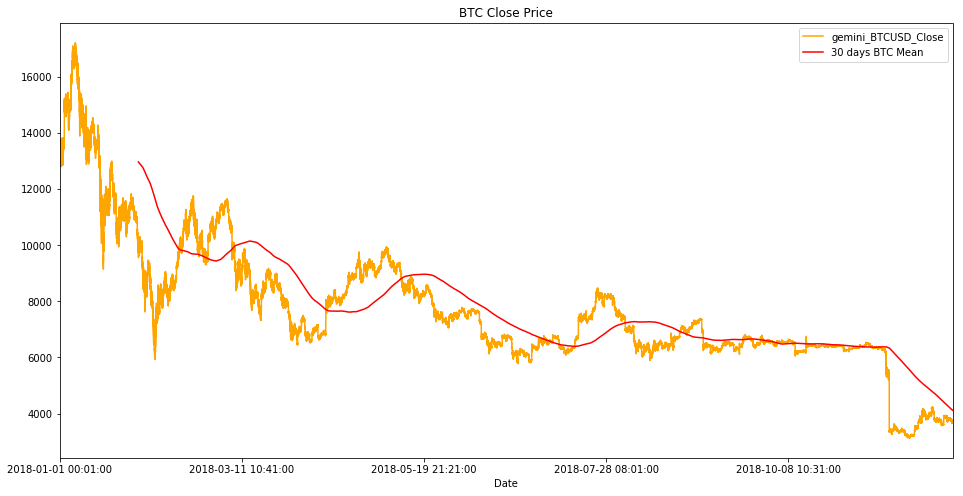

In [ ]:
df_rm['30 days BTC Mean'] = df_rm['gemini_BTCUSD_Close'].rolling(window=minutes_in_30days).mean()
df_rm[['gemini_BTCUSD_Close', '30 days BTC Mean']].plot(label='BTC',figsize=(16,8),title='BTC Close Price',color=['orange','red'])
plt.show()

Both coins price goes up and down of its own long term mean.

### 4. Implemenation
#### 4.1 Define Varibles for Lookback history sequence and Target column     

In [ ]:
# RNN model learn by lookback history
# the longer the lookback period the better, but more data will take longer to train
LOOKBACK_HISTORY_SEQ_LEN = 100 # look back last 100 minutes 

# How far we wish to predict the future?
PREDICT_FUTURE_SEQ_LEN = 5 # predict 5 minute in the future

# We are predicting the future price of Ethereum in exchange Gemini
PREDICT_COLUMN = 'gemini_ETHUSD_Close'

# Could switch to bitcoin, or any other altcoin for future development
# PREDICT_COLUMN = 'gemini_BTCUSD_Close' 

# Create a new column to hold the future price of Ethereum
# this allow the calculation of price raised or falled.
PREDICT_COLUMN_FUTUTE = '{}_Future'.format(PREDICT_COLUMN)

# The target label column 
# holding binary values indicate the future price is either: 
# If future price Raised, Action=Buy, Stored Value=1
# If future price Falled, Action=Sell, Stored Value=0
TARGET_LABEL = 'Target_Action'

In [ ]:
# Data Exploration - preview column data, and check no NaN
df_main[PREDICT_COLUMN]

Date
2018-01-01 00:01:00    737.98
2018-01-01 00:02:00    736.03
2018-01-01 00:03:00    738.29
2018-01-01 00:04:00    738.29
2018-01-01 00:05:00    735.00
2018-01-01 00:06:00    736.00
2018-01-01 00:07:00    736.20
2018-01-01 00:08:00    736.20
2018-01-01 00:09:00    736.20
2018-01-01 00:10:00    736.31
2018-01-01 00:11:00    736.21
2018-01-01 00:12:00    736.21
2018-01-01 00:13:00    736.20
2018-01-01 00:14:00    736.20
2018-01-01 00:15:00    735.00
2018-01-01 00:16:00    733.01
2018-01-01 00:17:00    733.01
2018-01-01 00:18:00    733.01
2018-01-01 00:19:00    732.99
2018-01-01 00:20:00    732.99
2018-01-01 00:21:00    732.99
2018-01-01 00:22:00    732.99
2018-01-01 00:23:00    732.99
2018-01-01 00:24:00    732.99
2018-01-01 00:25:00    732.99
2018-01-01 00:26:00    731.54
2018-01-01 00:27:00    730.61
2018-01-01 00:28:00    731.01
2018-01-01 00:29:00    733.00
2018-01-01 00:30:00    733.00
                        ...  
2018-12-31 23:30:00    130.91
2018-12-31 23:31:00    130.91
2018-

#### 4.2 Binary Classification
the binary values are Buy=1 or Sell=0<br/>
The function binary_classify() is map to the dataset to generate values in target column<br/>
if future price raised, then buy representation value 1 is assigned<br/>
if future price falled, then sell representation value 0 is assigned<br/>

In [ ]:
# Numeric Representation of Buy and Sell
SELL = 0
BUY = 1

# function to calculate values to assign target value in each data point.
def binary_classify(current_price, future_price):
    if(float(future_price) < float(current_price)):
        return SELL
    else:
        return BUY
    
def create_target_label_column(df):
    # create a new column for future price (the future price is already in dataset) 
    # shift target column data upwards to create the future data
    # there is now a current price and a future price for each data row
    # the current price and future price is then pass to binary_classify() to calculate target label buy/sell
    df[PREDICT_COLUMN_FUTUTE] = df[PREDICT_COLUMN].shift(-PREDICT_FUTURE_SEQ_LEN)

    # create a new column for target action buy or sell
    df[TARGET_LABEL] = list(map(binary_classify, df[PREDICT_COLUMN], df[PREDICT_COLUMN_FUTUTE])) 
    
    return df

df_main = create_target_label_column(df_main)

In [ ]:
# check data column values shifted by -5, and target label is correctly classified
df_main[[PREDICT_COLUMN, PREDICT_COLUMN_FUTUTE, TARGET_LABEL]].head(100)

,gemini_ETHUSD_Close,gemini_ETHUSD_Close_Future,Target_Action
Date,,,
2018-01-01 00:01:00,737.98,736.00,0
2018-01-01 00:02:00,736.03,736.20,1
2018-01-01 00:03:00,738.29,736.20,0
2018-01-01 00:04:00,738.29,736.20,0
2018-01-01 00:05:00,735.00,736.31,1
2018-01-01 00:06:00,736.00,736.21,1
2018-01-01 00:07:00,736.20,736.21,1
2018-01-01 00:08:00,736.20,736.20,1
2018-01-01 00:09:00,736.20,736.20,1


In [ ]:
number_of_buys = len(df_main[df_main[TARGET_LABEL] == BUY])
number_of_sells = len(df_main[df_main[TARGET_LABEL] == SELL])

print ('Number of Buys:', number_of_buys)
print ('Number of Sells:', number_of_sells)

if (number_of_buys > number_of_sells):
    print ('There are more Buys than Sells.')
elif (number_of_buys < number_of_sells):
    print ('There are more Sells than Buys.')
else:
    print ('There are equal number of Buys and Sells.')

Number of Buys: 276145
Number of Sells: 213961
There are more Buys than Sells.


#### 4.3 Data split for Training and Validation
training set 95% <br/>
validation set 05% <br/>
(while data still in correctly ordered in time sequence)<br/>

In [ ]:
def data_split(df):
    time_list = sorted(df.index.values)

    val_set_percentage = 0.05
    chop_at_time_index = -int(val_set_percentage * len(time_list))
    chop_at_time = sorted(df_main.index.values)[chop_at_time_index]

    df_train = df_main[(df_main.index < chop_at_time)]
    df_validation = df_main[(df_main.index >= chop_at_time)]

    return df_train, df_validation, chop_at_time
    
df_train, df_validation, chop_at_time = data_split(df_main)

print ('The dataset split at index time:', chop_at_time)
print ('The number of data points in training set:', len(df_train))
print ('The number of data points in validation set:', len(df_validation))


The dataset split at index time: 2018-12-14 23:35:00
The number of data points in training set: 465601
The number of data points in validation set: 24505


#### 4.4 Pre-processing data
step 1. drop future column - PREDICT_COLUMN_FUTUTE <br/>
step 2. normalize data by pct change <br/>
step 3. scale data close to 0 -> 1.0 <br/>
step 4. build sequences, each data point get 100 minutes lookback history <br/>
step 5. balance data to 50% buys 50% sells <br/>
step 6. package features as X, target as y, return <br/>

In [ ]:
from sklearn import preprocessing
from collections import deque
import random

def handle_features_zero(df):
    for col in df.columns:
        
        # avoid target as target is 1 or 0
        if col != TARGET_LABEL:
            
            # handling volume values 0.0, 
            # these 0.0 value will cause pct_change to error by divide by 0
            # replace 0.0 with NAN
            df[col].replace([0.0], [float('nan')], inplace=True) 

            # drop any data points have volume value 0.0, as it might be misleading
            df.dropna(inplace=True) 
            
    return df
    
# 2. normalize data - change values to pct change
def normalize_to_rate_of_change(df):
    for col in df.columns:
        if col != TARGET_LABEL:
            df[col] = df[col].pct_change()
            
    return df
    
# 3. scale data - change values to 0 -> 1.0
def scale(df):
    for col in df.columns:
        if col != TARGET_LABEL:
            df[col] = preprocessing.scale(df[col].values)
        
    # drop any nan as a result of normalize or scale
    df = handle_features_nan(df)
            
    return df
    
def handle_features_nan(df):
    df.dropna(inplace=True)
    return df
    
# 4. build sequences of history rows, last 100 minutes
def build_history_sequences(df):
    
    all_sequences = []
    next_sequence = deque(maxlen=LOOKBACK_HISTORY_SEQ_LEN)
    
    for data_row in df.values:
        # extract feature columns, ignore target column
        features_only_no_target = [n for n in data_row[:-1]]
        next_sequence.append(features_only_no_target)
    
        # once the sequence have enough length, 24 hours, then append ot main list
        if len(next_sequence) == LOOKBACK_HISTORY_SEQ_LEN:
            all_sequences.append([np.array(next_sequence), data_row[-1]])
            
    # shuffle to random spread data
    random.shuffle(all_sequences)
    
    return all_sequences
    
# 5. balance data to 50% buys 50% sells
def balance_data(all_sequences):
    buy_list = []
    sell_list = []
    
    # first seperate out the buys and sells 
    for seq, target in all_sequences:
        if target == SELL:
            sell_list.append([seq, target])
        elif target == BUY:
            buy_list.append([seq, target])

    random.shuffle(buy_list)
    random.shuffle(sell_list)
    
    # work out which havethe smaller len, the crop on that len
    lower_len = min(len(buy_list), len(sell_list))

    buy_list = buy_list[:lower_len]
    sell_list = sell_list[:lower_len]
    
    # join the list back together and shuffle to spread the buys and sells evenly
    balanced_sequences = buy_list + sell_list
    random.shuffle(balanced_sequences)
    
    return balanced_sequences
        
def package_data(balanced_sequences):
    X = []
    y = []
    
    for seq, target in balanced_sequences:
        X.append(seq)
        y.append(target)
        
    return np.array(X), y
        
def data_preprocessing(df):
    
    # 1. drop future column
    df = df.drop(PREDICT_COLUMN_FUTUTE, 1)
    
    # handle any nan values, by fill forward
    df.fillna(method='ffill')
        
    # remove any volumn with value 0.0
    df = handle_features_zero(df)
    
    # 2. normalize data - change values to pct change
    df = normalize_to_rate_of_change(df)
                        
    # 3. scale data - change values to 0 -> 1.0
    df = scale(df)
    
    # 4. build sequences of history rows, last 100 minutes
    all_sequences = build_history_sequences(df)

    # 5. balance data to 50% buys 50% sells
    balanced_sequences = balance_data(all_sequences)
    
    # 6. return features as X, target as y
    X, y = package_data(balanced_sequences)
    
    return X, y
    

The above code in data_preprocessing creates 4 sets:
- X Training
- y Training
- X Validation
- y Validation

In [ ]:
X_train, y_train = data_preprocessing(df_train)
X_val, y_val = data_preprocessing(df_validation)

#### 4.5 Save pre-processed data
Save the train sets and validation sets for future use.

In [ ]:
import pickle

save_to_folder = 'data/preprocessed/'

#create folder data if not exist
if not os.path.exists(save_to_folder):
    os.makedirs(save_to_folder)

save_file = save_to_folder + 'X_train.pickle'
pickle.dump(X_train, open(save_file, "wb"))
print ('Saved pre-processed data to pickle - %s' % save_file)

save_file = save_to_folder + 'y_train.pickle'
pickle.dump(y_train, open(save_file, "wb"))
print ('Saved pre-processed data to pickle - %s' % save_file)

save_file = save_to_folder + 'X_val.pickle'
pickle.dump(X_val, open(save_file, "wb"))
print ('Saved pre-processed data to pickle - %s' % save_file)

save_file = save_to_folder + 'y_val.pickle'
pickle.dump(y_val, open(save_file, "wb"))
print ('Saved pre-processed data to pickle - %s' % save_file)       


Saved pre-processed data to pickle - data/preprocessed/X_train.pickle
Saved pre-processed data to pickle - data/preprocessed/y_train.pickle
Saved pre-processed data to pickle - data/preprocessed/X_val.pickle
Saved pre-processed data to pickle - data/preprocessed/y_val.pickle


#### 4.6 Load pre-proocessed data
To Save time, next time in this notebook you dont have to run the previous code cells again, just run code from next cell to use the pre-processed data for RNN model training.

In [ ]:
# re-import used packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import datetime as time
from datetime import datetime
import warnings
import os
from tqdm import tnrange, tqdm_notebook
import time
import pickle


In [ ]:
# re-define variables
LOOKBACK_HISTORY_SEQ_LEN = 100 
PREDICT_FUTURE_SEQ_LEN = 5 
PREDICT_COLUMN = 'gemini_ETHUSD_Close'
PREDICT_COLUMN_FUTUTE = '{}_Future'.format(PREDICT_COLUMN)
TARGET_LABEL = 'Target_Action'


Load the training set and validation set back from previously saved pickle files:


In [ ]:
load_from_folder = 'data/preprocessed/'

load_file = load_from_folder + 'X_train.pickle'
X_train = pickle.load(open(load_file, "rb"))
print ('Loaded pre-processed data - %s' % load_file)

load_file = load_from_folder + 'y_train.pickle'
y_train = pickle.load(open(load_file, "rb"))
print ('Loaded pre-processed data - %s' % load_file)

load_file = load_from_folder + 'X_val.pickle'
X_val = pickle.load(open(load_file, "rb"))
print ('Loaded pre-processed data - %s' % load_file)

load_file = load_from_folder + 'y_val.pickle'
y_val = pickle.load(open(load_file, "rb"))
print ('Loaded pre-processed data - %s' % load_file)


Loaded pre-processed data - data/preprocessed/X_train.pickle
Loaded pre-processed data - data/preprocessed/y_train.pickle
Loaded pre-processed data - data/preprocessed/X_val.pickle
Loaded pre-processed data - data/preprocessed/y_val.pickle


In [ ]:
# check data len
print ('Size of X train data:', len(X_train))
print ('Size of y train data:', len(y_train))
print ('Size of X validation data:', len(X_val))
print ('Size of y validation data:', len(y_val))

Size of X train data: 240418
Size of y train data: 240418
Size of X validation data: 11446
Size of y validation data: 11446


In [ ]:
# check target buy=1, sell=0
print ('y train buys:', y_train.count(1))
print ('y train sells:', y_train.count(0))

print ('y validation buys:', y_val.count(1))
print ('y validation sells:', y_val.count(0))


y train buys: 120209
y train sells: 120209
y validation buys: 5723
y validation sells: 5723


### 5. RNN Model for Time Sequence 

#### 5.1 import deep learning and related packages

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, CuDNNLSTM, BatchNormalization
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import SGD, RMSprop, Adagrad, Adadelta, Adam, Adamax, Nadam
import time
import os
from glob import glob


#### 5.2 Tuning Hyper Parameters
fine tune model by executing combination of multiple hyper parameters

In [ ]:
EPOCHS = 10

# tuning hyper-parameters
lstm_layers = [2]
layer_sizes = [64] 
dense_layers = [1,2]
batch_sizes = [64,128]
dropouts = [0.2,0.25]
optimizers = [Adam]
learning_rates = [1e-3,1e-4]
decays = [1e-6,1e-7]
loss_functions = ['sparse_categorical_crossentropy']

###
# use best model hyper parameters, to speed up training time 
#
# *Model 35/128*
# exch-gemini-predict-gemini_ETHUSD_Close-lookback-100-future-5-lstm-2-nodes-128-dense-1-batch-64-dropout-0.2-optimizer-<class 'tensorflow.python.keras.optimizers.Adam'>-lr-0.0001-decay-1e-06
# Train on 240418 samples, validate on 11446 samples
# val_acc: 0.5744
# Test Loss:0.67945953966666
# Test Accuracy:0.5744364843925938
###    

# lstm_layers = [2]
# layer_sizes = [128] 
# dense_layers = [1]
# batch_sizes = [64]
# dropouts = [0.2]
# optimizers = [Adam]
# learning_rates = [1e-4]
# decays = [1e-6]
# loss_functions = ['sparse_categorical_crossentropy']

number_of_models = len(lstm_layers) \
                    *len(layer_sizes) \
                    *len(dense_layers) \
                    *len(batch_sizes) \
                    *len(dropouts) \
                    *len(optimizers) \
                    *len(learning_rates) \
                    *len(decays) \
                    *len(loss_functions)

print ('Number of models:', number_of_models)

# folders for model training and tensorboard
logs_to_folder = 'logs/'
if not os.path.exists(logs_to_folder):
    os.makedirs(logs_to_folder)
    
models_to_folder = 'models/'
if not os.path.exists(models_to_folder):
    os.makedirs(models_to_folder)

Number of models: 64


#### 5.3 Execute RNN model training on each combination of hyper-parameters.

In [ ]:

model_count = 0

for lstm_layer in lstm_layers:
    for layer_size in layer_sizes:
        for dense_layer in dense_layers:
            for batch_size in batch_sizes:
                for dropout in dropouts:
                    for optimizer in optimizers:
                        for lr in learning_rates:
                            for decay in decays:
                                for loss_function in loss_functions:
                                    model_name = 'exch-gemini'
                                    model_name += '-predict-'+PREDICT_COLUMN \
                                                + '-lookback-'+str(LOOKBACK_HISTORY_SEQ_LEN) \
                                                + '-future-'+str(PREDICT_FUTURE_SEQ_LEN)
                                    model_name += "-lstm-{}-nodes-{}-dense-{}-batch-{}-dropout-{}-optimizer-{}-lr-{}-decay-{}".format( \
                                                    lstm_layer, \
                                                    layer_size, \
                                                    dense_layer, \
                                                    batch_size, \
                                                    dropout, \
                                                    optimizer, \
                                                    lr, \
                                                    decay)

                                    model_count += 1

                                    print ('*Model {}/{}*'.format(model_count, number_of_models))
                                    print (model_name)

                                    # let user know if hyper parameters already trained
                                    # this could happen if kernal crash and restarted training
                                    check_logs_file = '{}/{}'.format(logs_to_folder, model_name)
                                    if glob(check_logs_file+'*'):
                                        print ('%s already exist.' % (check_logs_file))
                                        # continue

                                    # name of model by hyper-parameter values
                                    # to compare them all in tensorboard
                                    model_name += '-time-{}'.format(int(time.time()))

                                    # LSTM layers - minimum of 1
                                    model = Sequential()
                                    model.add(CuDNNLSTM(layer_size, input_shape=(X_train.shape[1:]), return_sequences=True))

                                    # how much to forget
                                    model.add(Dropout(dropout))

                                    # normalize output, the output is the input for the next LSTM layer
                                    model.add(BatchNormalization())

                                    # LSTM layers - add more
                                    for l in range(lstm_layer-1):
                                        model.add(CuDNNLSTM(layer_size, return_sequences=True))
                                        model.add(Dropout(dropout))
                                        model.add(BatchNormalization())

                                    model.add(CuDNNLSTM(layer_size))
                                    model.add(Dropout(dropout))

                                    # this LSTM layer do not need to return sequence, as the next layer is dense layer
                                    model.add(BatchNormalization())

                                    # Dense layers
                                    for _ in range(dense_layer):
                                        model.add(Dense(32, activation='relu'))
                                        model.add(Dropout(dropout))

                                    # the final layer only have 2 nodes for binary classification: Buy=1, Sell=0
                                    model.add(Dense(2, activation='softmax'))

                                    # optimizer
                                    #   learning rate
                                    #   learning decay
                                    # opt = tf.keras.optimizers.Adam(lr=1e-3, decay=1e-6)
                                    opt = optimizer(lr=lr, decay=decay)

                                    # compile 
                                    model.compile(optimizer=opt, loss=loss_function, metrics=['accuracy'])

                                    # save logs for tensorboard graphs
                                    tensorboard = TensorBoard(log_dir="{}/{}".format(logs_to_folder, model_name))

                                    # saves only the best ones
                                    filepath = "RNN_-{epoch:02d}-{val_acc:.3f}"
                                    checkpoint = ModelCheckpoint('{}/{}.model'.format(models_to_folder, filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')) 

                                    # training
                                    model.fit(X_train, y_train, epochs=EPOCHS, batch_size=batch_size, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint],)

                                    # score
                                    score = model.evaluate(X_val, y_val, verbose=0)

                                    # loss and accuracy
                                    loss = score[0]
                                    accuracy = score[1]
                                    print('Test Loss:{}'.format(loss))
                                    print('Test Accuracy:{}'.format(accuracy))

                                    # save model
                                    model.save('{}/{}'.format(models_to_folder, model_name))


*Model 1/64*
exch-gemini-predict-gemini_ETHUSD_Close-lookback-100-future-5-lstm-2-nodes-64-dense-1-batch-64-dropout-0.2-optimizer-<class 'tensorflow.python.keras.optimizers.Adam'>-lr-0.001-decay-1e-06
Train on 240418 samples, validate on 11446 samples
Epoch 1/10
176448/240418 [=====================>........] - ETA: 14s - loss: 0.6980 - acc: 0.5263

#### 5.4 Results

The model validation accuracy is above 0.5, the problem is solved.